In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [5]:
#Load Library 

import pandas as pd

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
import xgboost as xgb
import seaborn as sns

In [7]:
!which python 

/home/maksim/.config/jupyterlab-desktop/jlab_server/bin/python


In [6]:
!ls dataset

sample_submission.csv  test.csv  train.csv


In [8]:
# Загрузка данных
train_path = "dataset/train.csv"
test_path = "dataset/test.csv"


train_data=pd.read_csv(train_path)
test_data=pd.read_csv(test_path)

In [9]:
train_data.head(1)

,id,store_sales(in millions),unit_sales(in millions),total_children,num_children_at_home,avg_cars_at home(approx).1,gross_weight,recyclable_package,low_fat,units_per_case,store_sqft,coffee_bar,video_store,salad_bar,prepared_food,florist,cost
0,0,8.61,3.0,2.0,2.0,2.0,10.3,1.0,0.0,32.0,36509.0,0.0,0.0,0.0,0.0,0.0,62.09


In [10]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 360336 entries, 0 to 360335
Data columns (total 17 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   id                          360336 non-null  int64  
 1   store_sales(in millions)    360336 non-null  float64
 2   unit_sales(in millions)     360336 non-null  float64
 3   total_children              360336 non-null  float64
 4   num_children_at_home        360336 non-null  float64
 5   avg_cars_at home(approx).1  360336 non-null  float64
 6   gross_weight                360336 non-null  float64
 7   recyclable_package          360336 non-null  float64
 8   low_fat                     360336 non-null  float64
 9   units_per_case              360336 non-null  float64
 10  store_sqft                  360336 non-null  float64
 11  coffee_bar                  360336 non-null  float64
 12  video_store                 360336 non-null  float64
 13  salad_bar     

In [11]:
train_data.columns

Index(['id', 'store_sales(in millions)', 'unit_sales(in millions)',
       'total_children', 'num_children_at_home', 'avg_cars_at home(approx).1',
       'gross_weight', 'recyclable_package', 'low_fat', 'units_per_case',
       'store_sqft', 'coffee_bar', 'video_store', 'salad_bar', 'prepared_food',
       'florist', 'cost'],
      dtype='object')

In [12]:
#Checking missing value

train_data.isnull().sum()

id                            0
store_sales(in millions)      0
unit_sales(in millions)       0
total_children                0
num_children_at_home          0
avg_cars_at home(approx).1    0
gross_weight                  0
recyclable_package            0
low_fat                       0
units_per_case                0
store_sqft                    0
coffee_bar                    0
video_store                   0
salad_bar                     0
prepared_food                 0
florist                       0
cost                          0
dtype: int64

In [13]:

# List of features to check for outliers
features = ['store_sales(in millions)', 'unit_sales(in millions)', 'total_children',
            'num_children_at_home', 'avg_cars_at home(approx).1',
            'gross_weight', 'recyclable_package', 'low_fat', 'units_per_case', 'store_sqft', 'coffee_bar',
            'video_store', 'salad_bar', 'prepared_food', 'florist']

# Outlier detection using IQR method
def remove_outliers(df, features):
    # Calculate the IQR for each feature
    for feature in features:
        Q1 = df[feature].quantile(0.25)
        Q3 = df[feature].quantile(0.75)
        IQR = Q3 - Q1
        
        # Define bounds for detecting outliers
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        # Remove outliers
        df = df[(df[feature] >= lower_bound) & (df[feature] <= upper_bound)]
    return df




In [14]:

# Remove outliers
train_data_cleaned = remove_outliers(train_data.copy(), features)

In [15]:
train_data.shape

(360336, 17)

In [16]:
train_data_cleaned.shape

(312253, 17)

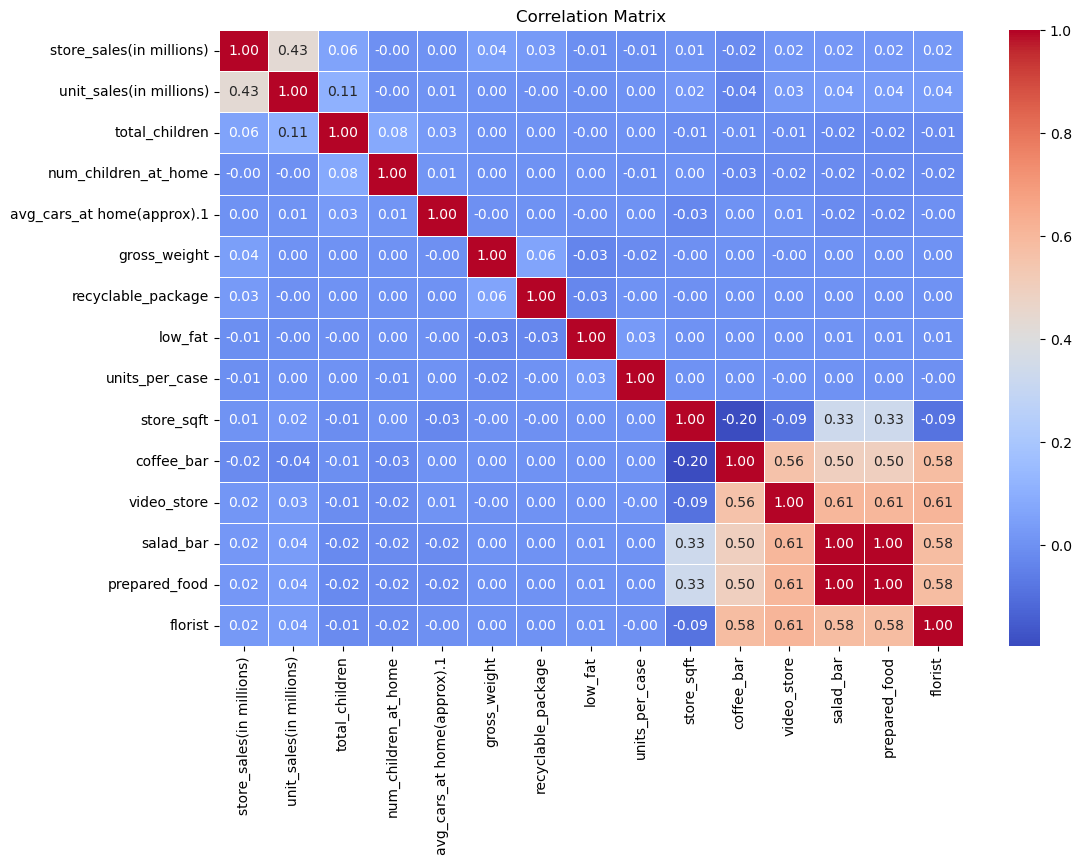

                       Feature          VIF
0                        const    73.778677
1     store_sales(in millions)     1.233791
2      unit_sales(in millions)     1.247764
3               total_children     1.020719
4         num_children_at_home     1.007905
5   avg_cars_at home(approx).1     1.002227
6                 gross_weight     1.007168
7           recyclable_package     1.005535
8                      low_fat     1.002801
9               units_per_case     1.001318
10                  store_sqft     1.552024
11                  coffee_bar     1.876625
12                 video_store     2.114832
13                   salad_bar  3544.474348
14               prepared_food  3544.337460
15                     florist     2.046721
Features with high VIF: ['const', 'salad_bar', 'prepared_food']
Highly correlated features: {'prepared_food'}
Features to drop: {'prepared_food', 'salad_bar', 'const'}
Selected features: ['store_sales(in millions)', 'unit_sales(in millions)', 'total_ch

In [18]:

from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
import seaborn as sns

# Step 1: Calculate correlation matrix
corr_matrix = train_data_cleaned[features].corr()

# Plot correlation heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

# Step 2: Calculate VIF for each feature
# Add constant to the data (for VIF calculation)
X = train_data_cleaned[features]
X_with_const = add_constant(X)  # Adds a constant column for VIF calculation

# Calculate VIF for each feature
vif_data = pd.DataFrame()
vif_data["Feature"] = X_with_const.columns
vif_data["VIF"] = [variance_inflation_factor(X_with_const.values, i) for i in range(X_with_const.shape[1])]

# Display VIF data
print(vif_data)

# Step 3: Feature selection based on VIF and correlation
# Thresholds for VIF and correlation
VIF_THRESHOLD = 10  # Features with VIF above 10 are considered to have high multicollinearity
CORR_THRESHOLD = 0.8  # Correlation greater than 0.8 means features are highly correlated

# Remove features with high VIF
high_vif_features = vif_data[vif_data['VIF'] > VIF_THRESHOLD]['Feature'].tolist()
print(f"Features with high VIF: {high_vif_features}")

# Remove features with high correlation
correlated_features = []
for i in range(len(corr_matrix.columns)):
    for j in range(i):
        if abs(corr_matrix.iloc[i, j]) > CORR_THRESHOLD:
            colname = corr_matrix.columns[i]
            correlated_features.append(colname)

print(f"Highly correlated features: {set(correlated_features)}")

# Combine features to drop: high VIF and high correlation
features_to_drop = set(high_vif_features + correlated_features)
print(f"Features to drop: {features_to_drop}")

# Final feature set after dropping highly correlated and high-VIF features
final_features = [f for f in features if f not in features_to_drop]
print(f"Selected features: {final_features}")

# Now, we can continue with feature selection
X_train_selected = train_data[final_features]

# Continue with your machine learning model training using X_train_selected


In [19]:
# After outlier removal, you can proceed with model training:
# Separate features and target variable again
X_train = train_data_cleaned.drop(columns=['id','cost','salad_bar', 'prepared_food'])  # Assuming 'MediaCost' is the target
y_train = train_data_cleaned['cost']

# Now you can continue with the training process as shown in the earlier response

In [20]:
X_train.head(1)

,store_sales(in millions),unit_sales(in millions),total_children,num_children_at_home,avg_cars_at home(approx).1,gross_weight,recyclable_package,low_fat,units_per_case,store_sqft,coffee_bar,video_store,florist
0,8.61,3.0,2.0,2.0,2.0,10.3,1.0,0.0,32.0,36509.0,0.0,0.0,0.0


In [21]:
X_test=test_data.drop(columns=['id','salad_bar', 'prepared_food']) 
X_test.head(2)

,store_sales(in millions),unit_sales(in millions),total_children,num_children_at_home,avg_cars_at home(approx).1,gross_weight,recyclable_package,low_fat,units_per_case,store_sqft,coffee_bar,video_store,florist
0,7.24,4.0,1.0,0.0,2.0,10.80,0.0,1.0,7.0,20319.0,0.0,0.0,0.0
1,6.90,2.0,2.0,2.0,3.0,8.51,1.0,0.0,4.0,33858.0,1.0,0.0,1.0


In [22]:
# For the test data, we need the same features, but without the target
X_test = test_data  # Test data doesn't have 'MediaCost'

# Step 3: Split train data into train and validation sets
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(X_train, y_train, test_size=0.2, random_state=42)


In [23]:
X_train_split.head(1)

,store_sales(in millions),unit_sales(in millions),total_children,num_children_at_home,avg_cars_at home(approx).1,gross_weight,recyclable_package,low_fat,units_per_case,store_sqft,coffee_bar,video_store,florist
84984,6.69,3.0,0.0,0.0,3.0,13.6,0.0,0.0,33.0,39696.0,0.0,0.0,0.0


In [24]:
X_val_split.head(2)

,store_sales(in millions),unit_sales(in millions),total_children,num_children_at_home,avg_cars_at home(approx).1,gross_weight,recyclable_package,low_fat,units_per_case,store_sqft,coffee_bar,video_store,florist
147586,6.39,3.0,0.0,0.0,3.0,12.6,1.0,0.0,2.0,39696.0,0.0,0.0,0.0
281010,5.25,3.0,3.0,0.0,1.0,10.6,1.0,0.0,17.0,21215.0,1.0,0.0,0.0


In [25]:
X_train_split.head(1)

,store_sales(in millions),unit_sales(in millions),total_children,num_children_at_home,avg_cars_at home(approx).1,gross_weight,recyclable_package,low_fat,units_per_case,store_sqft,coffee_bar,video_store,florist
84984,6.69,3.0,0.0,0.0,3.0,13.6,0.0,0.0,33.0,39696.0,0.0,0.0,0.0


In [26]:
y_train_split.head(1)

84984    118.25
Name: cost, dtype: float64

In [27]:
X_test.head(1)

,id,store_sales(in millions),unit_sales(in millions),total_children,num_children_at_home,avg_cars_at home(approx).1,gross_weight,recyclable_package,low_fat,units_per_case,store_sqft,coffee_bar,video_store,salad_bar,prepared_food,florist
0,360336,7.24,4.0,1.0,0.0,2.0,10.8,0.0,1.0,7.0,20319.0,0.0,0.0,0.0,0.0,0.0


In [30]:
model = xgb.XGBRegressor(
    objective='reg:squarederror', 
    n_estimators=1000, 
    learning_rate=0.01, 
    max_depth=5,
    early_stopping_rounds=50  # Перенесите параметр сюда
)

# Обучение модели
model.fit(
    X_train_split, 
    y_train_split, 
    eval_set=[(X_val_split, y_val_split)], 
    verbose=False
)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [31]:
X_test1=test_data.drop(columns=['id','salad_bar', 'prepared_food']) 

X_test1.head(1)

,store_sales(in millions),unit_sales(in millions),total_children,num_children_at_home,avg_cars_at home(approx).1,gross_weight,recyclable_package,low_fat,units_per_case,store_sqft,coffee_bar,video_store,florist
0,7.24,4.0,1.0,0.0,2.0,10.8,0.0,1.0,7.0,20319.0,0.0,0.0,0.0


In [32]:
# Step 5: Make predictions on the test set
y_pred = model.predict(X_test1)

In [33]:
y_pred 

array([102.41567 ,  98.174576,  97.012   , ...,  96.96867 , 108.71034 ,
       103.267075], shape=(240224,), dtype=float32)

In [34]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Make predictions on the validation set
y_pred = model.predict(X_val_split)

# Calculate MAE, RMSE, and R^2
mae = mean_absolute_error(y_val_split, y_pred)
rmse = np.sqrt(mean_squared_error(y_val_split, y_pred))
r2 = r2_score(y_val_split, y_pred)

# Print the evaluation metrics
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R-squared (R²): {r2}")


Mean Absolute Error (MAE): 24.50342105382006
Root Mean Squared Error (RMSE): 28.547005966636178
R-squared (R²): 0.09123691626015507


In [35]:
# Step 6: Export the submission file
# Prepare the submission dataframe (Kaggle typically expects 'Id' and 'MediaCost' columns in the submission)
submission = pd.DataFrame({
      # Ensure you have 'Id' in your test dataset
    'cost': y_pred
})

# Save the submission file as a CSV
submission.to_csv('submission.csv', index=False)

print("Submission file 'submission.csv' has been saved!")

Submission file 'submission.csv' has been saved!


In [36]:
submission.head(10)

,cost
0,96.594261
1,102.375145
2,107.338264
3,84.169266
4,88.711617
5,106.999596
6,94.203819
7,98.061668
8,100.398682
9,99.286682
